<a href="https://colab.research.google.com/github/piushag/591NR/blob/main/Adversarial_Attacks_Vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import torch
import torchvision
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt

In [25]:
def move_image_right(image, num_pixels):
    # Pad the left side of the image with zeros
    pad = torch.zeros((3, num_pixels, 32))
    padded_image = torch.cat((pad, image), dim=1)
    # Crop the right side of the image to remove the padded pixels
    cropped_image = padded_image[:, :32, :]
    # Return the moved image
    return cropped_image

def move_image_left(image, num_pixels):
    # Get the width of the image
    width = image.shape[2]
    # Create a tensor of zeros with the same dimensions as the original image
    moved_image = torch.zeros_like(image)
    # Copy the pixels from the original image to the moved image with a leftward shift
    moved_image[:, :, :width-num_pixels] = image[:, :, num_pixels:]
    # Return the moved image
    return moved_image

def move_image_up(image, num_pixels):
    # Get the height of the image
    height = image.shape[1]
    # Create a tensor of zeros with the same dimensions as the original image
    moved_image = torch.zeros_like(image)
    # Copy the pixels from the original image to the moved image with an upward shift
    moved_image[:, :height-num_pixels, :] = image[:, num_pixels:, :]
    # Return the moved image
    return moved_image

def move_image_down(image, num_pixels):
    # Get the height of the image
    height = image.shape[1]
    # Create a tensor of zeros with the same dimensions as the original image
    moved_image = torch.zeros_like(image)
    # Copy the pixels from the original image to the moved image with a downward shift
    moved_image[:, num_pixels:, :] = image[:, :height-num_pixels, :]
    # Return the moved image
    return moved_image

def add_pixel_noise(image, theta):
  new_image = image + theta
  return new_image


def get_right_diff_channel(image):
    right_image = move_image_right(image,3)
    return torch.mean((image-right_image), dim=0, keepdim=True)

def get_left_diff_channel(image):
    left_image = move_image_left(image,3)
    return torch.mean((image-left_image), dim=0, keepdim=True)

def get_up_diff_channel(image):
    up_image = move_image_up(image,3)
    return torch.mean((image-up_image), dim=0, keepdim=True)

def get_down_diff_channel(image):
    down_image = move_image_down(image,3)
    return torch.mean((image-down_image), dim=0, keepdim=True)

def get_pixel_noise_channel(image, theta):
  noisy_image = add_pixel_noise(image, theta)
  return torch.mean((image-noisy_image), dim=0, keepdim=True) 

class AddNewChannels:
    """Add a fourth channel to the CIFAR-10 images with all zero values."""
    def __call__(self, img):
        return torch.cat((img, get_right_diff_channel(img), get_left_diff_channel(img), get_up_diff_channel(img), get_down_diff_channel(img), get_pixel_noise_channel(img, 0.3), get_pixel_noise_channel(img, -0.3)), dim=0)


In [26]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

device = get_default_device()

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
  


Files already downloaded and verified
Files already downloaded and verified
[1,   100] loss: 2.234
[1,   200] loss: 1.995
[1,   300] loss: 1.934
[2,   100] loss: 1.794
[2,   200] loss: 1.712
[2,   300] loss: 1.672
[3,   100] loss: 1.530
[3,   200] loss: 1.481
[3,   300] loss: 1.411
[4,   100] loss: 1.323
[4,   200] loss: 1.299
[4,   300] loss: 1.250
[5,   100] loss: 1.195
[5,   200] loss: 1.167
[5,   300] loss: 1.169
[6,   100] loss: 1.086
[6,   200] loss: 1.085
[6,   300] loss: 1.048
[7,   100] loss: 1.018
[7,   200] loss: 0.979
[7,   300] loss: 0.987
[8,   100] loss: 0.941
[8,   200] loss: 0.932
[8,   300] loss: 0.909
[9,   100] loss: 0.885
[9,   200] loss: 0.852
[9,   300] loss: 0.872
[10,   100] loss: 0.825
[10,   200] loss: 0.815
[10,   300] loss: 0.813
[11,   100] loss: 0.791
[11,   200] loss: 0.768
[11,   300] loss: 0.771
[12,   100] loss: 0.741
[12,   200] loss: 0.730
[12,   300] loss: 0.746
[13,   100] loss: 0.692
[13,   200] loss: 0.688
[13,   300] loss: 0.711
[14,   100] los

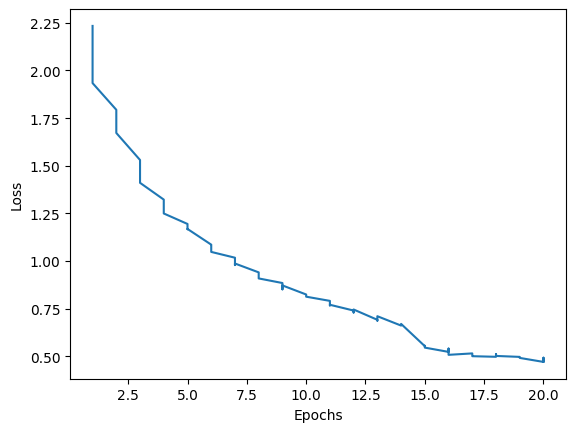

Finished Training
Accuracy of VGG-19 on the 10000 test images: 79 %


In [27]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    AddNewChannels(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
])

# Define the transformations to be applied to the data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    AddNewChannels(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
])

# Load the CIFAR-10 dataset
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Load a SqueezeNet model
net = torchvision.models.vgg19(num_classes=10)

# Modify the first convolutional layer to accept 6 channels
net.features[0] = torch.nn.Conv2d(6, 64, kernel_size=3, stride=2)
net.features[0] = torch.nn.Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
to_device(net,device)


# Train the model
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
decayRate = 0.1
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

import array

epochs = array.array('i')
losses = array.array('f')

for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    if (epoch+1)%15==0:
        my_lr_scheduler.step()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            epochs.append(epoch+1)
            losses.append(running_loss/100)
            running_loss = 0.0

plt.plot(epochs, losses)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

print('Finished Training')

# Evaluate the model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of VGG-19 on the 10000 test images: %d %%' % (100 * correct / total))


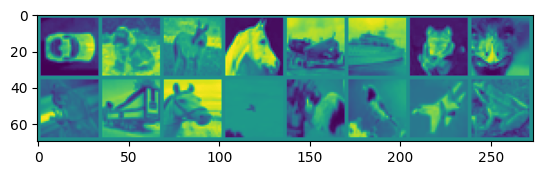

GroundTruth:    car   dog  deer horse plane  ship  frog  bird  frog truck horse plane   cat  bird plane  frog
Predicted:    car   dog  deer horse plane  ship  frog   car  frog horse horse plane   cat  bird plane  frog


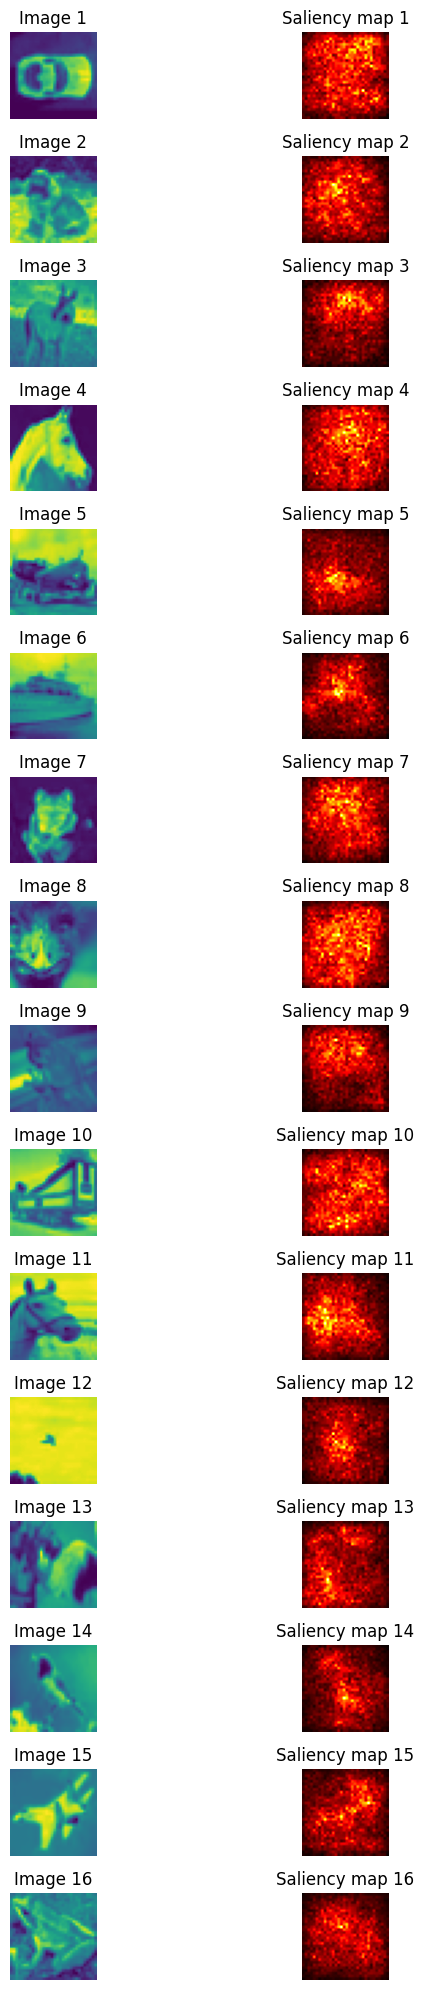

In [31]:
import random
import torch
import torch.nn.functional as F
from captum.attr import Saliency
import matplotlib.pyplot as plt

def imshow(img, transpose=True):
    img = img / 2 + 0.5     # unnormalize
    img = np.clip(img, 0, 1) # clip pixel values to [0,1]
    npimg = img.numpy()
    if transpose:
        npimg = np.transpose(npimg, (0, 2, 3, 1))  # transpose to (batch_size, height, width, channels)
    plt.imshow(npimg[0])
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)

# Select 16 random images
random_indices = random.sample(range(len(images)), k=16)
images = images[random_indices]
labels = labels[random_indices]

images = images.to(device)  # Move the input data to the appropriate device
labels = labels.to(device)  # Move the labels to the appropriate device

net.to(device)  # Move the model to the appropriate device

outputs = net(images)

_, predicted = torch.max(outputs, 1)

# Print images
imshow(torchvision.utils.make_grid(images.cpu()), transpose=False)  # Move images to CPU for displaying
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j].item()] for j in range(16)))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j].item()] for j in range(16)))

# Rest of your code...


saliency = Saliency(net)


fig, axs = plt.subplots(nrows=len(images), ncols=2, figsize=(8, 20))
for i in range(len(images)):
    image = images[i].unsqueeze(0)
    npimg = image.cpu().numpy()
    npimg = npimg.squeeze()
    axs[i, 0].imshow(npimg[0], cmap='viridis')
    axs[i, 0].set_title(f"Image {i+1}")
    
    net.eval()
    image.requires_grad_()
    scores = net(image)

    score_max_index = scores.argmax()
    score_max = scores[0,score_max_index]

    score_max.backward()

    saliency, _ = torch.max(image.grad.data.abs(),dim=1)
    axs[i, 1].imshow(saliency.cpu().numpy()[0], cmap=plt.cm.hot)
    axs[i, 1].set_title(f"Saliency map {i+1}")
    
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [32]:
# Define the adversarial attack
def fgsm_attack(image, epsilon, data_grad):
    # Calculate the sign of the gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adding the signed gradient to the original image
    perturbed_image = image + epsilon * sign_data_grad
    # Clip the perturbed image so that its pixel values are between 0 and 1
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [33]:
import torch.nn.functional as F

# Generate adversarial examples for the test dataset using FGSM attack
epsilon = 0.1
correct = 0
total = 0
for data in testloader:
    # Get the input image and label
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    # Set requires_grad attribute of tensor to True, since we want to compute the gradient with respect to the input image
    images.requires_grad = True
    # Forward pass the input image through the model
    outputs = net(images)
    # Calculate the loss
    loss = F.cross_entropy(outputs, labels)
    # Zero out the gradients
    net.zero_grad()
    # Backward pass to compute the gradient
    loss.backward()
    # Get the gradient of the loss with respect to the input image
    data_grad = images.grad.data
    # Call the adversarial attack function to generate the perturbed image
    perturbed_image = fgsm_attack(images, epsilon, data_grad)
    outputs = net(perturbed_image)
    # Get the predicted label for the perturbed image
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Adversarial accuracy of VGG-19 on the 10000 test images: %d %%' % (100 * correct / total))

Adversarial accuracy of VGG-19 on the 10000 test images: 16 %
